# Machine Learning for Early Alzheimer’s Risk Prediction
### A Data-Driven Approach Using Biometric and Biographical Features

##### By Anakin Liu, Jerry Xia, Ruiyuan Yang

<br/>

<br/>

## Packages Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_recall_curve, 
    classification_report, 
    confusion_matrix,
    make_scorer
)
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings("ignore")

<br/>

<br/>

## Data Preprocessing

In [3]:
raw_data = pd.read_csv('alzheimers_prediction_dataset.csv')
col_names = raw_data.columns.to_list()
raw_data.head()

,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
0,Spain,90,Male,1,33.0,Medium,Never,Occasionally,No,No,...,Healthy,High,Retired,Single,No,Low,Medium,High,Urban,No
1,Argentina,72,Male,7,29.9,Medium,Former,Never,No,No,...,Healthy,Medium,Unemployed,Widowed,No,High,Low,High,Urban,No
2,South Africa,86,Female,19,22.9,High,Current,Occasionally,No,Yes,...,Average,Medium,Employed,Single,No,Low,Medium,High,Rural,No
3,China,53,Male,17,31.2,Low,Never,Regularly,Yes,No,...,Healthy,Medium,Retired,Single,No,High,Medium,Low,Rural,No
4,Sweden,58,Female,3,30.0,High,Former,Never,Yes,No,...,Unhealthy,High,Employed,Married,No,Low,Medium,High,Rural,No


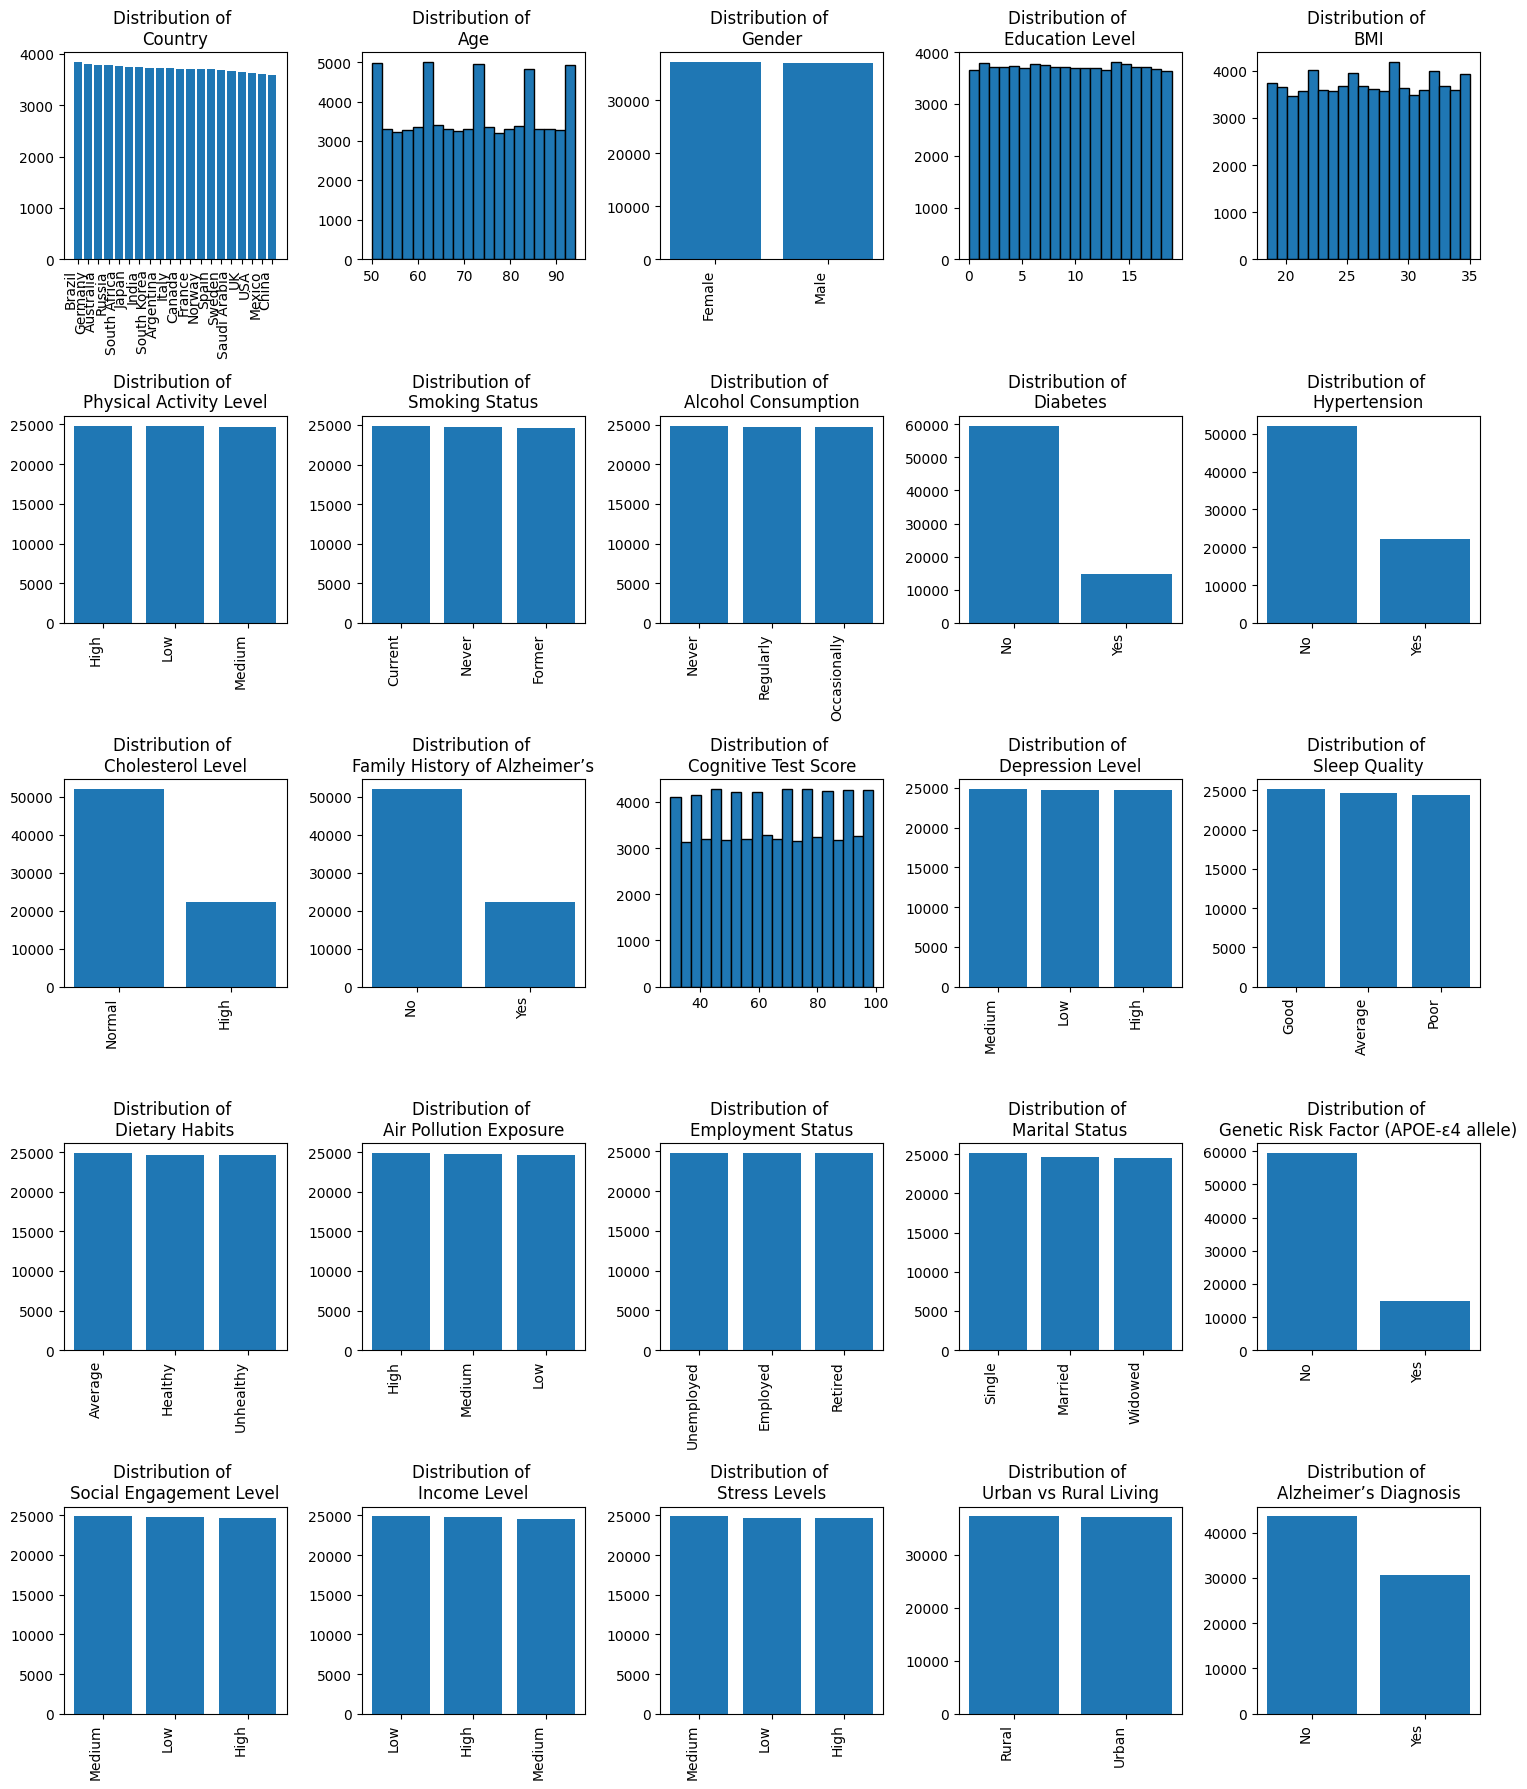

In [ ]:
# NaN and duplication cleaning
raw_data.dropna(inplace=True)
raw_data.drop_duplicates(inplace=True)


# Basic data info
scaler = StandardScaler()

plt.figure(figsize=(15, (len(col_names) // 5 + 1) * 3))
for i in range(len(col_names)):
    plt.subplot((len(col_names)+4)//5, 5, i+1)
    column_i = raw_data[col_names[i]]
    if column_i.dtype == 'object':
        value_counts = column_i.value_counts()
        plt.bar(value_counts.index, value_counts.values)
        plt.xticks(rotation=90, ha='right')
    else:
        plt.hist(column_i, bins=20, edgecolor='black')
        raw_data[col_names[i]] = scaler.fit_transform(column_i.values.reshape(-1, 1))

    plt.title(f'Distribution of \n{col_names[i]}')

plt.tight_layout()
plt.show()


# Categorical variables to dummies
categorical_cols = raw_data.select_dtypes(include=['object']).columns

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(raw_data[categorical_cols])
encoded_cats = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))

encoded_data = pd.concat([raw_data.drop(columns=categorical_cols).reset_index(drop=True), encoded_cats], axis=1)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    encoded_data.iloc[:, :-1].values, 
    encoded_data.iloc[:, -1],
    test_size=0.2,
    random_state=7
)

**Insights:** According to the distribution visualization, though some features show signs of imbalance, there is no severe imbalance in the features or the label, indicating a potentially reliable result can be drawn from this dataset.

<br/>

<br/>

## Baseline: Logistic Regression

Accuracy: 0.7143
ROC-AUC Score: 0.7899
Classification Report:
               precision    recall  f1-score   support

         0.0     0.7383    0.7884    0.7625      8644
         1.0     0.6749    0.6111    0.6414      6213

    accuracy                         0.7143     14857
   macro avg     0.7066    0.6998    0.7020     14857
weighted avg     0.7118    0.7143    0.7119     14857



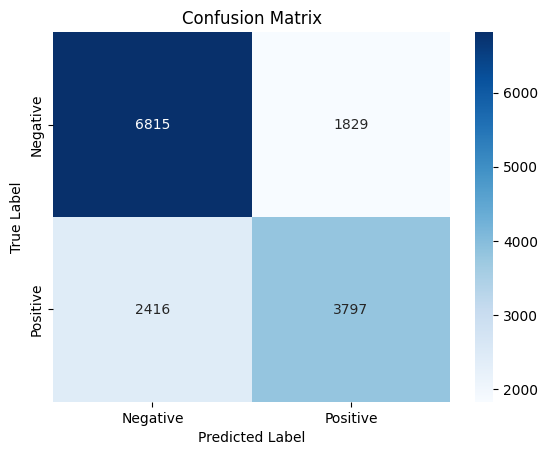

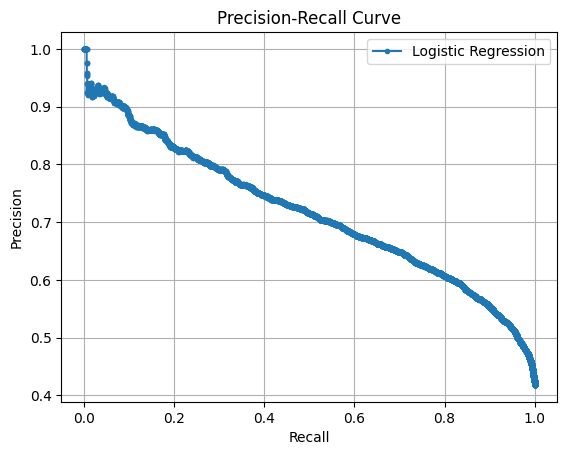

In [5]:
logit_reg = LogisticRegression(max_iter=1000, random_state=7)
logit_reg.fit(X_train, y_train)

# Predictions
y_pred = logit_reg.predict(X_test)
y_prob = logit_reg.predict_proba(X_test)[:, 1]

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, digits=4)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", class_report)

# Plot confusion matrix
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='Blues', 
    xticklabels=["Negative", "Positive"], 
    yticklabels=["Negative", "Positive"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

<br/>

<br/>

## Lasso Feature Selection

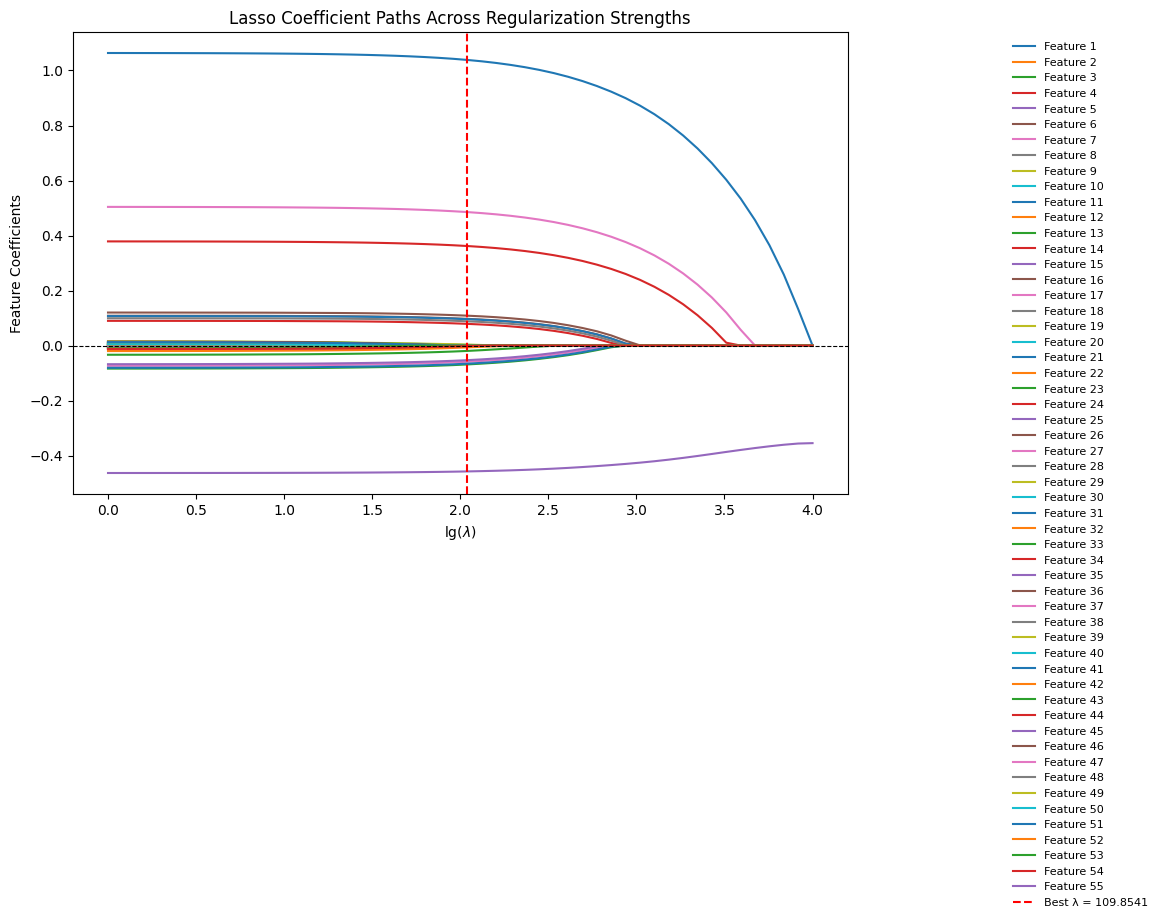

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso and cross-validation
lambdas = np.logspace(0, 4, 50)
lasso_cv = LogisticRegressionCV(
    penalty='l1', solver='saga', Cs=1/lambdas, cv=5, scoring='roc_auc', random_state=7, max_iter=5000
)
lasso_cv.fit(X_train_scaled, y_train)

# Best lambda
best_lambda = 1 / lasso_cv.C_[0]

# Train final Lasso Logistic Regression using the best lambda
lasso_best = LogisticRegression(penalty='l1', solver='saga', C=1/best_lambda, random_state=7, max_iter=5000)
lasso_best.fit(X_train_scaled, y_train)

# Store selected features
selected_features = np.array(encoded_data.columns[:-1])[lasso_best.coef_.flatten() != 0]

# Average coefficients across CV folds
coefs_mean = np.mean(lasso_cv.coefs_paths_[1], axis=0)

# Plot coefficient paths
plt.figure(figsize=(10, 6))
for i in range(coefs_mean.shape[1]):
    plt.plot(np.log10(lambdas), coefs_mean[:, i], label=f"Feature {i+1}")

plt.axvline(np.log10(best_lambda), color='red', linestyle='--', label=f'Best λ = {best_lambda:.4f}')
plt.xlabel(r'$\lg(\lambda)$')
plt.ylabel("Feature Coefficients")
plt.title("Lasso Coefficient Paths Across Regularization Strengths")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), ncol=1, fontsize=8, frameon=False)
plt.show()

<br/>

# Random Forest

In [ ]:
# Create the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Random Forest Accuracy: 0.7171030490677796

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.78      0.76      8644
         1.0       0.67      0.64      0.65      6213

    accuracy                           0.72     14857
   macro avg       0.71      0.71      0.71     14857
weighted avg       0.72      0.72      0.72     14857


Confusion Matrix:
[[6701 1943]
 [2260 3953]]


<br/>

## Random Forest with GridSearch Cross-Validation

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=7)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best estimator found
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Test Accuracy: 0.7236992663390994

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77      8644
         1.0       0.68      0.63      0.66      6213

    accuracy                           0.72     14857
   macro avg       0.72      0.71      0.71     14857
weighted avg       0.72      0.72      0.72     14857


Confusion Matrix:
[[6818 1826]
 [2279 3934]]


<br/>

## Random Forest with Randomized Cross-Validation

In [ ]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
rf_model = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=30,                # you can adjust this
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# 7. Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}
Best Cross-Validation Score: 0.7250024652230123

Test Accuracy: 0.725112741468668

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.73      0.76      8644
         1.0       0.66      0.71      0.68      6213

    accuracy                           0.73     14857
   macro avg       0.72      0.72      0.72     14857
weighted avg       0.73      0.73      0.73     14857


Confusion Matrix:
[[6350 2294]
 [1790 4423]]


<br/>

## Gradient Boosting

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
gb_model = GradientBoostingClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=skf,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.01}
Best cross-validation score: 0.7276444877294896

Test Accuracy: 0.7249781247896614

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.76      8644
         1.0       0.67      0.67      0.67      6213

    accuracy                           0.72     14857
   macro avg       0.72      0.72      0.72     14857
weighted avg       0.72      0.72      0.72     14857


Confusion Matrix:
[[6615 2029]
 [2057 4156]]


<br/>

## Gradient Boosting 
##### Optimizing towards **FP** + using advanced searches + expanding search range

In [ ]:
# Scoring function to minimize false positive rate
def fp_rate_scorer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]

    fp_rate = FP / (TN + FP) if (TN + FP) > 0 else 0.0
    return 1 - fp_rate

custom_fp_scorer = make_scorer(fp_rate_scorer, greater_is_better=True)
param_dist = {
    'n_estimators': [200, 250, 300, 350, 400],
    'learning_rate': [0.005, 0.01, 0.015, 0.02],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Gradient Boosting
gb_model = GradientBoostingClassifier(
    random_state=42,
    n_iter_no_change=10,
    validation_fraction=0.1
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configure BayesSearchCV with the custom FP rate scorer
bayes_search = BayesSearchCV(
    estimator=gb_model,
    search_spaces=param_dist,
    n_iter=20,
    cv=skf,
    scoring=custom_fp_scorer,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
bayes_search.fit(X_train, y_train)
print("Best parameters:", bayes_search.best_params_)
print("Best cross-validation score (1 - FP rate):", bayes_search.best_score_)

# Evaluate the best model on the test set
best_model = bayes_search.best_estimator_
y_pred = best_model.predict(X_test)

# Compute and display the false positive rate on the test set
cm = confusion_matrix(y_test, y_pred)
TN, FP = cm[0, 0], cm[0, 1]
fp_rate_value = FP / (TN + FP) if (TN + FP) > 0 else 0.0

print("\nTest False Positive Rate:", fp_rate_value)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(cm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

<br/>

## Try to Eliminate FP with GB

In [ ]:
# Compute sample weights to penalize misclassifying negatives
sample_weight = np.where(y_train == 0, 2.0, 1.0)
param_dist = {
    'n_estimators': [200, 250, 300, 350, 400],
    'learning_rate': [0.005, 0.01, 0.015, 0.02],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Gradient Boosting with early stopping
gb_model = GradientBoostingClassifier(
    random_state=42,
    n_iter_no_change=10,
    validation_fraction=0.1
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configure BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=gb_model,
    search_spaces=param_dist,
    n_iter=20,
    cv=skf,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
bayes_search.fit(X_train, y_train, sample_weight=sample_weight)
print("Best parameters:", bayes_search.best_params_)
print("Best cross-validation score:", bayes_search.best_score_)

# Decision Threshold Adjustment
best_model = bayes_search.best_estimator_
probs = best_model.predict_proba(X_test)[:, 1]
threshold = 0.8
y_pred_adjusted = (probs >= threshold).astype(int)

# Evaluate the adjusted predictions
accuracy = accuracy_score(y_test, y_pred_adjusted)
print("\nTest Accuracy with adjusted threshold:", accuracy)
print("\nClassification Report with adjusted threshold:")
print(classification_report(y_test, y_pred_adjusted))
print("\nConfusion Matrix with adjusted threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

<br/>

## Further Threshold-Tuning

In [ ]:
best_model = bayes_search.best_estimator_
probs = best_model.predict_proba(X_test)[:, 1]

# Adjusted threshold
threshold = 0.85
y_pred_adjusted = (probs >= threshold).astype(int)

# Evaluate the adjusted predictions
accuracy = accuracy_score(y_test, y_pred_adjusted)
print("\nTest Accuracy with adjusted threshold:", accuracy)
print("\nClassification Report with adjusted threshold:")
print(classification_report(y_test, y_pred_adjusted))
print("\nConfusion Matrix with adjusted threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))


Test Accuracy with adjusted threshold: 0.5984384465235243

Classification Report with adjusted threshold:
              precision    recall  f1-score   support

         0.0       0.59      1.00      0.74      8714
         1.0       1.00      0.03      0.06      6143

    accuracy                           0.60     14857
   macro avg       0.80      0.51      0.40     14857
weighted avg       0.76      0.60      0.46     14857


Confusion Matrix with adjusted threshold:
[[8714    0]
 [5966  177]]


<br/>

## Feature Importance Visualization

Feature ranking:
1. Feature 'Age' with importance: 0.5940
2. Feature 'Genetic Risk Factor (APOE-ε4 allele)_Yes' with importance: 0.1282
3. Feature 'Family History of Alzheimer’s_Yes' with importance: 0.0665
4. Feature 'BMI' with importance: 0.0251
5. Feature 'Cognitive Test Score' with importance: 0.0225
6. Feature 'Education Level' with importance: 0.0184
7. Feature 'Country_Russia' with importance: 0.0050
8. Feature 'Country_India' with importance: 0.0047
9. Feature 'Country_Brazil' with importance: 0.0047
10. Feature 'Country_South Africa' with importance: 0.0041
11. Feature 'Urban vs Rural Living_Urban' with importance: 0.0039
12. Feature 'Gender_Male' with importance: 0.0039
13. Feature 'Cholesterol Level_Normal' with importance: 0.0039
14. Feature 'Hypertension_Yes' with importance: 0.0038
15. Feature 'Depression Level_Medium' with importance: 0.0038
16. Feature 'Income Level_Low' with importance: 0.0038
17. Feature 'Alcohol Consumption_Occasionally' with importance: 0.0037
18. F

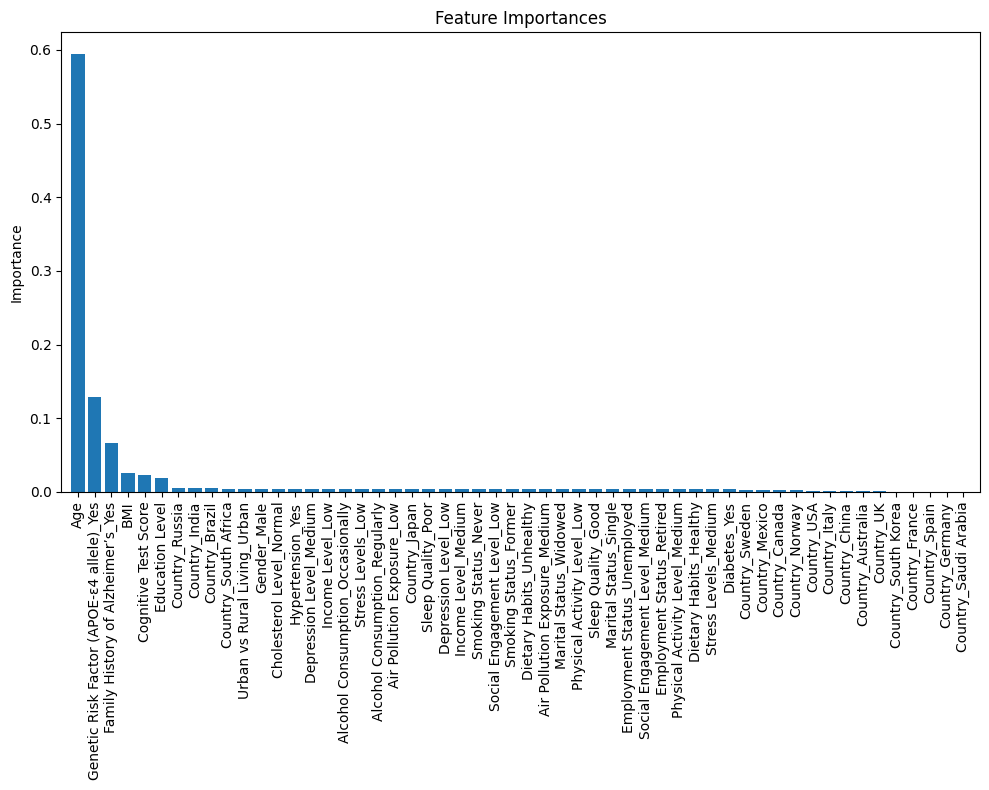

In [ ]:
feature_names = encoded_data.columns[:-1]
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i, idx in enumerate(indices):
    print(f"{i + 1}. Feature '{feature_names[idx]}' with importance: {importances[idx]:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

<br/>

## Initial Trys to Optimize Towards **FP**

In [ ]:
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train, y_train)

# Default predictions
y_pred_baseline = rf_baseline.predict(X_test)

# Evaluate baseline
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_baseline).ravel()
baseline_acc = accuracy_score(y_test, y_pred_baseline)
print("=== Baseline Random Forest ===")
print(f"Accuracy: {baseline_acc:.3f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("--------------------------------\n")

# Adjust the Classification Threshold Manually
rf_threshold = RandomForestClassifier(random_state=42)
rf_threshold.fit(X_train, y_train)

probs = rf_threshold.predict_proba(X_test)[:, 1]
custom_threshold = 0.8
y_pred_thresh = (probs >= custom_threshold).astype(int)

# Evaluate
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
acc = accuracy_score(y_test, y_pred_thresh)
print("=== Approach #1: Custom Threshold ===")
print(f"Threshold: {custom_threshold}")
print(f"Accuracy: {acc:.3f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("--------------------------------\n")

# Custom Cost Function in RandomizedSearchCV
def custom_cost_function(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 1*fn

    return -cost

custom_scorer = make_scorer(custom_cost_function)

param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# RandomizedSearchCV with custom scoring
rf_for_custom_cost = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_for_custom_cost,
    param_distributions=param_dist,
    n_iter=5,
    scoring=custom_scorer,
    cv=skf,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train, y_train)

print("=== Approach #2: Custom Cost Function ===")
print("Best params:", random_search.best_params_)
best_model = random_search.best_estimator_

# Evaluate on test set
y_pred_custom_cost = best_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom_cost).ravel()
acc = accuracy_score(y_test, y_pred_custom_cost)
print(f"Accuracy: {acc:.3f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("--------------------------------\n")

# Adjust Class Weights
rf_class_weight = RandomForestClassifier(
    random_state=42,
    class_weight={0: 1.0, 1: 0.2}
)
rf_class_weight.fit(X_train, y_train)

y_pred_weighted = rf_class_weight.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_weighted).ravel()
acc = accuracy_score(y_test, y_pred_weighted)
print("=== Approach #3: Adjust Class Weights ===")
print(f"Accuracy: {acc:.3f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("--------------------------------\n")

# Systematic Threshold Tuning Post-Training
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

rf_tune = RandomForestClassifier(random_state=42)
rf_tune.fit(X_subtrain, y_subtrain)

val_probs = rf_tune.predict_proba(X_val)[:, 1]

# Explore thresholds from 0 to 1 in steps of 0.01
thresholds = np.linspace(0, 1, 101)
lowest_fp = float('inf')
best_thresh = 0.0

for t in thresholds:
    val_preds = (val_probs >= t).astype(int)
    tn_, fp_, fn_, tp_ = confusion_matrix(y_val, val_preds).ravel()
    if fp_ < lowest_fp:
        lowest_fp = fp_
        best_thresh = t

print("=== Approach #4: Systematic Threshold Tuning ===")
print(f"Best threshold to minimize FP: {best_thresh}, with {lowest_fp} false positives")

rf_tune_full = RandomForestClassifier(random_state=42)
rf_tune_full.fit(X_train, y_train)

# Apply the chosen threshold to the test set
test_probs = rf_tune_full.predict_proba(X_test)[:, 1]
y_pred_tuned = (test_probs >= best_thresh).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tuned).ravel()
acc = accuracy_score(y_test, y_pred_tuned)
print(f"Accuracy with threshold={best_thresh:.2f}: {acc:.3f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("--------------------------------\n")

=== Baseline Random Forest ===
Accuracy: 0.720
Confusion Matrix: TN=6761, FP=1883, FN=2274, TP=3939
--------------------------------

=== Approach #1: Custom Threshold ===
Threshold: 0.8
Accuracy: 0.611
Confusion Matrix: TN=8587, FP=57, FN=5715, TP=498
--------------------------------

Fitting 3 folds for each of 5 candidates, totalling 15 fits
=== Approach #2: Custom Cost Function ===
Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
Accuracy: 0.700
Confusion Matrix: TN=7927, FP=717, FN=3744, TP=2469
--------------------------------

=== Approach #3: Adjust Class Weights ===
Accuracy: 0.721
Confusion Matrix: TN=6553, FP=2091, FN=2057, TP=4156
--------------------------------

=== Approach #4: Systematic Threshold Tuning ===
Best threshold to minimize FP: 0.9500000000000001, with 0 false positives
Accuracy with threshold=0.95: 0.582
Confusion Matrix: TN=8644, FP=0, FN=6209, TP=4
--------------------------------



<br/>

## Speed up using randomized search and other methods

In [ ]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

# Use 3-fold CV to speed things up further
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Baseline Random Forest
print("=== Baseline Random Forest with RandomizedSearchCV ===")
baseline_rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=baseline_rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=skf,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_baseline = random_search.best_estimator_

y_pred_base = best_baseline.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_base).ravel()
acc = accuracy_score(y_test, y_pred_base)
print("Best Params:", random_search.best_params_)
print(f"Accuracy: {acc:.3f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("--------------------------------\n")

# Custom Threshold
print("=== Approach #1: Custom Threshold ===")
probs = best_baseline.predict_proba(X_test)[:, 1]

custom_threshold = 0.8
y_pred_thresh = (probs >= custom_threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
acc = accuracy_score(y_test, y_pred_thresh)
print(f"Threshold: {custom_threshold}")
print(f"Accuracy: {acc:.3f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("--------------------------------\n")

# Custom Cost Function in RandomizedSearchCV
print("=== Approach #2: Custom Cost Function ===")

def custom_cost_function(y_true, y_pred):
    tn_, fp_, fn_, tp_ = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp_ + 1*fn_
    return -cost

custom_scorer = make_scorer(custom_cost_function, greater_is_better=True)

rf_custom_cost = RandomForestClassifier(random_state=42)
cost_random_search = RandomizedSearchCV(
    estimator=rf_custom_cost,
    param_distributions=param_dist,
    n_iter=10,
    scoring=custom_scorer,
    cv=skf,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

cost_random_search.fit(X_train, y_train)
best_rf_cost = cost_random_search.best_estimator_

y_pred_cost = best_rf_cost.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_cost).ravel()
acc = accuracy_score(y_test, y_pred_cost)
print("Best Params:", cost_random_search.best_params_)
print(f"Accuracy: {acc:.3f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("--------------------------------\n")

# Adjust Class Weights
print("=== Approach #3: Class Weights ===")

param_dist_weights = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [
        {0: 1.0, 1: 0.2},
        {0: 1.0, 1: 0.5},
        'balanced_subsample'
    ]
}

rf_weights = RandomForestClassifier(random_state=42)
weight_random_search = RandomizedSearchCV(
    estimator=rf_weights,
    param_distributions=param_dist_weights,
    n_iter=10,
    scoring='accuracy',
    cv=skf,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

weight_random_search.fit(X_train, y_train)
best_rf_weight = weight_random_search.best_estimator_
y_pred_weight = best_rf_weight.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_weight).ravel()
acc = accuracy_score(y_test, y_pred_weight)
print("Best Params:", weight_random_search.best_params_)
print(f"Accuracy: {acc:.3f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("--------------------------------\n")

# Systematic Threshold Tuning
print("=== Approach #4: Systematic Threshold Tuning ===")

# Sub-split from X_train for threshold tuning
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=42
)

# Retrain best_baseline on subtrain
best_baseline.fit(X_subtrain, y_subtrain)
val_probs = best_baseline.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0, 1, 101)
lowest_fp = float('inf')
best_thresh = 0.0

for t in thresholds:
    val_preds = (val_probs >= t).astype(int)
    tn_, fp_, fn_, tp_ = confusion_matrix(y_val, val_preds).ravel()
    if fp_ < lowest_fp:
        lowest_fp = fp_
        best_thresh = t

print(f"Best threshold to minimize FP on validation set: {best_thresh:.2f} (FP={lowest_fp})")

# Retrain on the full training set
best_baseline.fit(X_train, y_train)
test_probs = best_baseline.predict_proba(X_test)[:, 1]
y_pred_tuned = (test_probs >= best_thresh).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tuned).ravel()
acc = accuracy_score(y_test, y_pred_tuned)
print(f"Accuracy at threshold={best_thresh:.2f}: {acc:.3f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("--------------------------------\n")

=== Baseline Random Forest with RandomizedSearchCV ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
Accuracy: 0.748
Confusion Matrix: TN=7316, FP=1398, FN=2344, TP=3799
--------------------------------

=== Approach #1: Custom Threshold ===
Threshold: 0.8
Accuracy: 0.596
Confusion Matrix: TN=8714, FP=0, FN=6008, TP=135
--------------------------------

=== Approach #2: Custom Cost Function ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}
Accuracy: 0.743
Confusion Matrix: TN=7674, FP=1040, FN=2783, TP=3360
--------------------------------

=== Approach #3: Class Weights ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 1, 